In [1]:
# import libraries 
#from imutils import paths 
import cv2
import keras
from keras.preprocessing.image import img_to_array
import os
import numpy as np 
import time 
from sklearn.model_selection import train_test_split
from pathlib import Path, PureWindowsPath, PurePath, PosixPath
from skimage.io import imread
import pandas as pd 
from matplotlib import pyplot as plt
from matplotlib import image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SeparableConv2D
from collections import defaultdict
from keras.layers.normalization import BatchNormalization
from keras.models import Model

Using TensorFlow backend.


In [2]:
#'C:/Users/D/Desktop/Java/MachineLearning/7. Machine Learning Capstone/Data/chest_xray/'
p = Path('/home/ec2-user/src/Data/ChestXray/chest_xray/').glob('**/*')
dir = [x for x in p if x.is_dir()]

source_dir = dir[3:]

In [3]:
print(source_dir) 

[PosixPath('/home/ec2-user/src/Data/ChestXray/chest_xray/val/PNEUMONIA'), PosixPath('/home/ec2-user/src/Data/ChestXray/chest_xray/val/NORMAL'), PosixPath('/home/ec2-user/src/Data/ChestXray/chest_xray/train/PNEUMONIA'), PosixPath('/home/ec2-user/src/Data/ChestXray/chest_xray/train/NORMAL'), PosixPath('/home/ec2-user/src/Data/ChestXray/chest_xray/test/PNEUMONIA'), PosixPath('/home/ec2-user/src/Data/ChestXray/chest_xray/test/NORMAL')]


In [4]:

# normal = 0
# sick = 1
data_topic = 'valPneumonia valNormal trainPneumonia trainNormal testPneumonia testNormal'.split()
data_folder = defaultdict(list)

for x, path in enumerate(source_dir):
    for img in path.glob('*.jpeg'):
        if x % 2 == 0:
            data_folder[data_topic[x]].append((img,1))
        else:
            data_folder[data_topic[x]].append((img,0))         
                                            

In [5]:
totals = []

for x in range(len(data_topic)):
    totals.append(len(data_folder[data_topic[x]]))
    
print(totals)

[8, 8, 3875, 1341, 390, 234]


In [10]:
# create data frame bar chart..


totals = np.asarray(totals)

totals = np.reshape(totals,(1,6))

total_data = pd.DataFrame(totals , columns = data_topic)


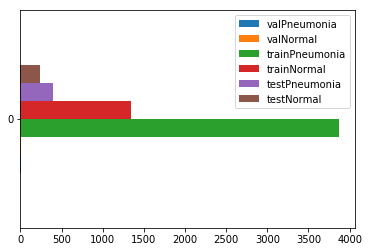

In [11]:
total_data.plot(kind ='barh')
plt.show()

#print(total_data)

In [12]:
def createXy(normalData, PneumoniaData):
    # data is a tuple list 
    data = list(normalData) + list(PneumoniaData)
    
    xLabels = []
    yLabels = []
    num = len(data)
    print(num)
    for x in range(num):
        imgPath = data[x][0]
        img = cv2.imread(str(imgPath))
        img = cv2.resize(img, (288,288))
        img = img.astype(np.float32)/255.
        xLabels.append(img)
        label = data[x][1]
        label = to_categorical(label, num_classes = 2)
        yLabels.append(label)
        
        yDim = np.squeeze(yLabels, axis =1)
        
        xArrayLabels = np.asarray(xLabels)
        yArrayLabels = np.asarray(yDim)
        
                    
    return xArrayLabels, yArrayLabels
        
    

In [13]:
# arrays of x and y train,val data

Xtrain, Ytrain= createXy(data_folder['trainNormal'],data_folder['trainPneumonia'] )
Xval, Yval= createXy(data_folder['valNormal'],data_folder['valPneumonia'])

5216
16


In [14]:
# arrays of x and y test data
Xtest, Ytest= createXy(data_folder['testNormal'],data_folder['testPneumonia'])

624


In [128]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu', input_shape=(288, 288, 3)))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=4))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=4))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(300, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 288, 288, 32)      1568      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 288, 288, 32)      4128      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 72, 72, 64)        8256      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 72, 72, 64)        16448     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 18, 18, 128)       32896     
__________

In [129]:
model.compile(loss='categorical_crossentropy', optimizer ='rmsprop', metrics =['accuracy'])

In [130]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

model.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 5216 samples, validate on 16 samples
Epoch 1/20
5216/5216 [==============================] - 58s - loss: 0.3017 - acc: 0.8855 - val_loss: 0.6106 - val_acc: 0.6250
Epoch 2/20
5216/5216 [==============================] - 57s - loss: 0.1360 - acc: 0.9507 - val_loss: 1.3656 - val_acc: 0.6250
Epoch 3/20
5216/5216 [==============================] - 58s - loss: 0.1007 - acc: 0.9659 - val_loss: 0.3231 - val_acc: 0.9375
Epoch 4/20
5216/5216 [==============================] - 58s - loss: 0.0931 - acc: 0.9693 - val_loss: 0.2395 - val_acc: 0.9375
Epoch 5/20
5216/5216 [==============================] - 58s - loss: 0.0769 - acc: 0.9737 - val_loss: 0.0943 - val_acc: 0.9375
Epoch 6/20
5216/5216 [==============================] - 57s - loss: 0.0638 - acc: 0.9814 - val_loss: 0.6988 - val_acc: 0.9375
Epoch 7/20
5216/5216 [==============================] - 57s - loss: 0.0607 - acc: 0.9835 - val_loss: 0.2695 - val_acc: 0.9375
Epoch 8/20
5216/5216 [==============================] - 57s - loss: 0.07

In [131]:
# load the weights 
model.load_weights('model.weights.best.hdf5')

In [132]:
score = model.evaluate(Xtest, Ytest, verbose=0) 
print('\n', 'Test accuracy:', score[1])



 Test accuracy: 0.793269230769


In [133]:
from sklearn.metrics import confusion_matrix
import pylab as pl

predictions = model.predict(Xtest)


In [134]:
np.argmax(predictions, axis =1)

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [135]:
np.argmax(Ytest, axis =1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

[[108 126]
 [  3 387]]


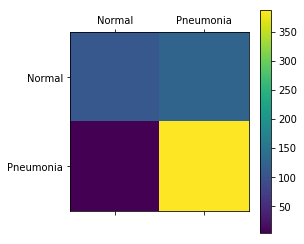

In [136]:

pl.figure()
matrix = confusion_matrix(np.argmax(Ytest, axis =1), np.argmax(predictions, axis =1))
print(matrix)
a = pl.matshow(matrix)

pl.xticks(range(2), ['Normal', 'Pneumonia'])
pl.yticks(range(2), ['Normal', 'Pneumonia'])

pl.colorbar(a)
pl.show()

In [137]:
trueNegative,  falseNegative, falsePositive, truePositive,  = matrix.ravel()

#print(truePositive)
#print(falseNegative) # predicted sick 1, when you are not 0

precision = truePositive/(truePositive+falsePositive)
recall = truePositive/(truePositive+falseNegative)

print("precision: ", precision)

print("recall: ", recall)

precision:  0.992307692308
recall:  0.754385964912
